In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

In [2]:
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES_Cells_2021/contacts/"

cell = "run11"

df_list = []
for f in os.listdir(dirpath):
    if cell in f:
        filepath = f"{dirpath}{f}"
        tmp = pd.read_parquet(filepath)
        tmp['batch_id'] = f.split("_")[2]
        
        df_list.append(tmp)
        
        
raw = pd.concat(df_list)
print(f"{raw.shape=}")
raw.head()

raw.shape=(4758260, 38)


,read_name,read_length,read_idx,contact_is_direct,contact_is_cis,contact_read_distance,contact_genome_distance,contact_fragment_adjacent,contact_fragment_distance,haplotype_pair_type,...,align2_strand,align2_mapping_quality,align2_align_score,align2_align_base_qscore,align2_phase_set,align2_haplotype,align2_fragment_id,align2_fragment_start,align2_fragment_end,batch_id
0,00017ed5-4634-45f5-867b-fe4240a8ecb0,2914,7549,True,False,657,0,False,0,trans,...,True,250,690,13,0,-1,8058890,36680633,36681628,batch2
1,00017ed5-4634-45f5-867b-fe4240a8ecb0,2914,7549,False,False,976,0,False,0,trans,...,False,244,539,9,0,-1,8273229,82955137,82955398,batch2
2,00017ed5-4634-45f5-867b-fe4240a8ecb0,2914,7549,True,True,-656,46272664,False,46274138,unphased,...,False,244,539,9,0,-1,8273229,82955137,82955398,batch2
3,0002b9b6-cb76-4f8c-b358-d66173dd03c9,4624,672,True,True,-43,-403,True,0,unphased,...,False,14,70,15,0,-1,785513,165544234,165544609,batch2
4,0002b9b6-cb76-4f8c-b358-d66173dd03c9,4624,672,False,True,120,-354,True,380,unphased,...,False,158,124,13,0,-1,785514,165544609,165544994,batch2


In [3]:
assembly = pd.read_csv("GRCm39_Assembly.txt")
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession
0,1,195154279,CM000994.3,NC_000067.7
1,2,181755017,CM000995.3,NC_000068.8
2,3,159745316,CM000996.3,NC_000069.7
3,4,156860686,CM000997.3,NC_000070.7
4,5,151758149,CM000998.3,NC_000071.7
5,6,149588044,CM000999.3,NC_000072.7
6,7,144995196,CM001000.3,NC_000073.7
7,8,130127694,CM001001.3,NC_000074.7
8,9,124359700,CM001002.3,NC_000075.7
9,10,130530862,CM001003.3,NC_000076.7


In [5]:
# get just chromosome 2 intra interactions
chomosome = 1
chrom_assembly = assembly.loc[assembly['Chromosome'] == str(chomosome)]
refseq = chrom_assembly['RefSeq accession'][0].strip()

mask = (raw['align1_chrom'] == refseq) & (raw['align2_chrom'] == refseq)

df = raw[mask]
print(f"{df.shape=}")

df.shape=(416120, 38)


In [8]:
chrom_length = chrom_assembly['Total length'][0]
# scale = 100000 #100kb scale
scale = 1000000 # 1mb scale


def getBins(chrom_length, scale):
    n = int(np.ceil(chrom_length / scale))    
    bins = [scale]
    
    for i in range(n-1):
        next_bin = bins[i] + scale
        bins.append(next_bin)
        
    return np.array(bins)



def returnBin(position, bins):
    idx = np.min(np.argwhere(bins > position))
    return idx - 1 


def binData(df, bins):
    df['align1_bin'] = df['align1_fragment_start'].apply(lambda x: returnBin(x, bins))
    df['align2_bin'] = df['align2_fragment_start'].apply(lambda x: returnBin(x, bins))
    return df
    

bins = getBins(chrom_length, scale)
print(f"{len(bins)=}")


test = binData(df, bins)
print(f"{test['align1_bin'].min()=}")
print(f"{test['align1_bin'].max()=}")

print(f"{test['align2_bin'].min()=}")
print(f"{test['align2_bin'].max()=}")
    

len(bins)=196


<ipython-input-8-4d9672b03945>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['align1_bin'] = df['align1_fragment_start'].apply(lambda x: returnBin(x, bins))


test['align1_bin'].min()=2
test['align1_bin'].max()=194
test['align2_bin'].min()=2
test['align2_bin'].max()=194


<ipython-input-8-4d9672b03945>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['align2_bin'] = df['align2_fragment_start'].apply(lambda x: returnBin(x, bins))


In [9]:
def constructHiC(df, bins):
    A = np.zeros((len(bins), len(bins)))
    
    for ind, row in df.iterrows():
        i = row['align1_bin']
        j = row['align2_bin']
        A[i, j] = A[i, j] + 1
        A[j, i] = A[j, i] + 1
    
    return A

A = constructHiC(df, bins)
print(f"{A.shape=}")

A.shape=(196, 196)


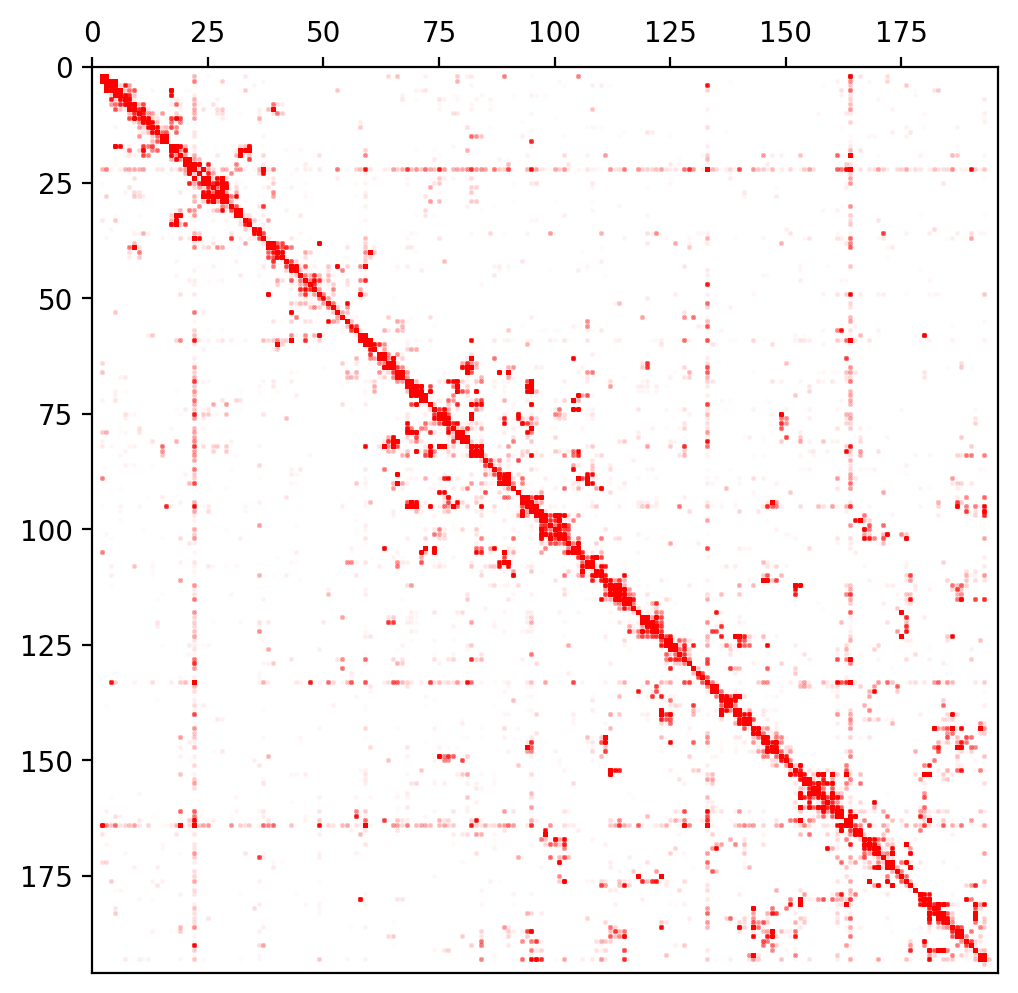

In [26]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

size = 1
alpha = 0.01
color = 'r'

plt.scatter(df['align2_bin'], df['align1_bin'], marker='s', s=size, alpha=alpha, c=color)
plt.scatter(df['align1_bin'], df['align2_bin'], marker='s', s=size, alpha=alpha, c=color)

plt.xlim(0, len(bins))
plt.ylim(len(bins), 0)
ax = plt.gca() # Get current axes object
ax.xaxis.set_ticks_position('top')
plt.gca().set_aspect('equal', adjustable='box')
